# INF 385T.9 - Data Wrangling

## Untangling Type'cast' Patterns 
A Data-driven Exploration of Netflix Shows, Actors, IMDb Ratings, and Genre Dynamics

Group 14

Kritika Patade, 
Shaunak Pusalkar

Fall 2023

## Installing libraries

In [1]:
!pip install jupysql --quiet
!pip install duckdb-engine --quiet
import duckdb
import csv

%reload_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///duckdb-file.db

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Deploy AI and data apps for free on Ploomber Cloud! Learn more: https://docs.cloud.ploomber.io/en/latest/quickstart/signup.html


## Create tables

In [2]:
%%sql

DROP TABLE IF EXISTS people;
DROP SEQUENCE IF EXISTS seq_person_id;
CREATE SEQUENCE seq_person_id START 1;
CREATE TABLE people (
    id INT PRIMARY KEY DEFAULT NEXTVAL('seq_person_id'),
    name TEXT,
);

DROP TABLE IF EXISTS shows;
DROP SEQUENCE IF EXISTS seq_show_id;
CREATE SEQUENCE seq_show_id START 1;
CREATE TABLE shows (
    id INT PRIMARY KEY DEFAULT NEXTVAL('seq_show_id'),
    name TEXT,
    rating TEXT,
    duration INT,
    date_added TEXT,
    release_year TEXT,
    description TEXT,
    "type" TEXT
);

DROP TABLE IF EXISTS genres;
DROP SEQUENCE IF EXISTS seq_genre_id;
CREATE SEQUENCE seq_genre_id START 1;
CREATE TABLE genres (
    id INT PRIMARY KEY DEFAULT NEXTVAL('seq_genre_id'),
    name TEXT
);

DROP TABLE IF EXISTS countries;
DROP SEQUENCE IF EXISTS seq_country_id;
CREATE SEQUENCE seq_country_id START 1;
CREATE TABLE countries (
    id INT PRIMARY KEY DEFAULT NEXTVAL('seq_country_id'),
    name TEXT
);


DROP TABLE IF EXISTS roles;
DROP SEQUENCE IF EXISTS seq_role_id;
CREATE SEQUENCE seq_role_id START 1;
CREATE TABLE roles (
    id INT PRIMARY KEY DEFAULT NEXTVAL('seq_role_id'),
    name TEXT
);


DROP TABLE IF EXISTS production_sites;
DROP SEQUENCE IF EXISTS seq_production_site_id;
CREATE SEQUENCE seq_production_site_id START 1;
CREATE TABLE production_sites (
    id INT PRIMARY KEY DEFAULT NEXTVAL('seq_production_site_id'),
    country_id INT,
    total_library_size TEXT,
    cost_per_title_basic_with_ads TEXT,
    cost_per_title_basic FLOAT,
    cost_per_title_standard TEXT,
    cost_per_title_premium TEXT
);


DROP TABLE IF EXISTS country_synonyms;
DROP SEQUENCE IF EXISTS seq_country_synonym_id;
CREATE SEQUENCE seq_country_synonym_id START 1;
CREATE TABLE country_synonyms (
    id INT PRIMARY KEY DEFAULT NEXTVAL('seq_country_synonym_id'),
    country_id INT,
    name TEXT
);

DROP TABLE IF EXISTS imdb_shows_original;
CREATE TABLE imdb_shows_original AS SELECT * FROM read_csv('imdb_shows.tsv',delim = '	',header = true, columns = {'tconst': 'TEXT', 'titleType': 'TEXT','primaryTitle': 'TEXT','originalTitle': 'TEXT','isAdult':'INT','startYear':'TEXT','endYear':'TEXT','runtimeMinutes': 'TEXT','genres': 'TEXT'},quote='"');
DROP TABLE IF EXISTS imdb_shows;
CREATE TABLE imdb_shows AS
SELECT tconst AS id, primaryTitle AS name, startYear as year FROM imdb_shows_original;


DROP TABLE IF EXISTS imdb_ratings_original;
CREATE TABLE imdb_ratings_original AS SELECT * FROM read_csv('imdb_ratings.tsv',delim = '	',header = true, columns = {'tconst': 'TEXT', 'averageRating': 'FLOAT', 'numVotes': 'INT'},quote='"');
DROP TABLE IF EXISTS imdb_ratings;
CREATE TABLE imdb_ratings AS
SELECT tconst AS id, averageRating AS rating FROM imdb_ratings_original;

  

--ASSOCIATION
DROP TABLE IF EXISTS show_crew;
CREATE TABLE show_crew (
    show_id INT,
    person_id INT,
    role_id INT
);


--ASSOCIATION
DROP TABLE IF EXISTS production_sites_shows;
CREATE TABLE production_sites_shows (
    show_id INT,
    production_site_id INT
);


--ASSOCIATION
DROP TABLE IF EXISTS genres_shows;
CREATE TABLE genres_shows (
    show_id INT,
    genre_id INT
);




,Count


In [3]:
%%sql

INSERT INTO roles(name) VALUES('director');
INSERT INTO roles(name) VALUES('cast');
SELECT * FROM roles;

,id,name
0,1,director
1,2,cast


## Add records from source files to tables

In [4]:
with duckdb.connect('duckdb-file.db') as con:

    sql_find_country = "SELECT id FROM countries WHERE name = $new_name"
    sql_insert_country = """
INSERT INTO countries(name) VALUES ($new_name) RETURNING id
"""
    sql_insert_country_synonyms = """
    INSERT INTO country_synonyms(name, country_id) VALUES ($new_name, $new_country_id)
    """


    with open('country_synonyms.csv') as csvfile:
            myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')

            for row in myCSVReader:  

                #COUNTRY_SYNONYMS
                
                #treat first column as original country name
                country_name = row.pop("name1")
                #remove columns that are not required
                row.pop("ID")
                row.pop("ISO3")
                param_dict_country = {"new_name" : country_name}
                con.execute(sql_find_country, param_dict_country)
                id_check = con.fetchone() # returns None if no rows found
                if (id_check == None):
                    con.execute(sql_insert_country, param_dict_country)
                    country_id = con.fetchone()[0]
                else:
                    country_id = id_check[0]
                
                for key,value in row.items():
                    if ((value != "") and (value != "null")):
                        param_dict_country_synonyms = {"new_name": value, "new_country_id": country_id}
                        con.execute(sql_insert_country_synonyms, param_dict_country_synonyms)
                
                

In [5]:
with duckdb.connect('duckdb-file.db') as con:

    sql_find_country = "SELECT id FROM countries WHERE name = $new_name"
    sql_insert_country = """
INSERT INTO countries(name) VALUES ($new_name) RETURNING id
"""
    
    sql_find_country_synonym = "SELECT country_id FROM country_synonyms WHERE name = $new_name"
    
    sql_insert_production_sites = """
    INSERT INTO production_sites(total_library_size, cost_per_title_basic_with_ads, cost_per_title_basic, cost_per_title_standard, cost_per_title_premium, country_id) VALUES ($new_total_library_size, $new_cost_per_title_basic_with_ads, $new_cost_per_title_basic, $new_cost_per_title_standard, $new_cost_per_title_premium, $new_country_id) RETURNING id
    """


    with open('data-m9a3x.csv') as csvfile:
            myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')

            for row in myCSVReader:  

                #PRODUCTION_SITES
                country_name = row['Country']
                param_dict_country = {"new_name" : country_name}
                #check if the country exists as a synonym first
                con.execute(sql_find_country_synonym, param_dict_country)
                id_check = con.fetchone() # returns None if no rows found
                if (id_check == None):
                    #check if the country already exists in the countries table
                    con.execute(sql_find_country, param_dict_country)
                    id_check = con.fetchone()
                    if (id_check == None):
                        #insert new country in countries table
                        con.execute(sql_insert_country,param_dict_country)
                        country_id = con.fetchone()[0]
                    else:
                        country_id = id_check[0]
                else:
                    country_id = id_check[0]
                
                param_dict_production_sites = {"new_country_id": country_id, "new_total_library_size": row['Total Library Size'], "new_cost_per_title_basic_with_ads":  row['Cost per Title - Basic with Ads ($)'], "new_cost_per_title_basic": row['Cost per Title - Basic ($)'] ,"new_cost_per_title_standard": row['Cost per Title - Standard ($)'], "new_cost_per_title_premium":  row['Cost per Title - Premium ($)']}
                con.execute(sql_insert_production_sites, param_dict_production_sites)
                


In [6]:
from datetime import datetime

with duckdb.connect('duckdb-file.db') as con:
    #con.execute("SET autocommit = 0")

    sql_find_show = "SELECT id FROM shows WHERE name = $new_name"
    sql_insert_show = """
INSERT INTO shows(name,date_added, release_year,rating, duration, description, type) VALUES ($new_name,$new_date_added,$new_release_year,$new_rating,$new_duration,$new_description,$new_type) RETURNING id
""" 
    sql_find_person = "SELECT id FROM people WHERE name = $new_name"
    sql_insert_person = """
INSERT INTO people(name) VALUES ($new_name) RETURNING id
""" 
    
    sql_find_country = "SELECT id FROM countries WHERE name = $new_name"
    sql_insert_country = """
INSERT INTO countries(name) VALUES ($new_name) RETURNING id
"""
    
    sql_find_country_synonym = "SELECT country_id FROM country_synonyms WHERE name = $new_name"
    
    sql_find_genre = "SELECT id FROM genres WHERE name = $new_name"
    sql_insert_genre = """
INSERT INTO genres(name) VALUES ($new_name) RETURNING id
"""
    
    sql_insert_assoc_genres_shows = """INSERT INTO genres_shows(genre_id, show_id) VALUES ($genre_id, $show_id)"""
    
    sql_find_role = """SELECT * FROM roles where name = $new_name"""
    
    sql_insert_assoc_show_crew = """INSERT INTO show_crew(show_id, role_id, person_id) VALUES($show_id, $role_id, $person_id)"""
    
    sql_find_production_site = """SELECT id FROM production_sites WHERE country_id = $country_id"""
    
    sql_insert_assoc_production_sites_shows = """INSERT INTO production_sites_shows(production_site_id, show_id) VALUES ($production_site_id, $show_id)"""
    
    with open('netflix_titles.csv') as csvfile:
        myCSVReader = csv.DictReader(csvfile, delimiter=",", quotechar='"')

        for row in myCSVReader:
            
            #SHOWS
            param_dict_show_name = {'new_name': row['title']}
            
            #convert duration values with various units into a single mins unit
            if 'min' in str.lower(row['duration']):
                duration_modified = int(row['duration'].split(' ')[0])
            elif 'season' in str.lower(row['duration']):
                duration_modified = int(row['duration'].split(' ')[0])*180
            else:
                duration_modified = 0
            
            
            param_dict_show_records = {'new_name': row['title'], 'new_date_added': row['date_added'],'new_release_year':row['release_year'],'new_rating':row['rating'],'new_duration':duration_modified,'new_description':row['description'],'new_type':row['type']}
            con.execute(sql_find_show, param_dict_show_name)
            id_check = con.fetchone() # returns None if no rows found
            if (id_check == None):
                con.execute(sql_insert_show, param_dict_show_records)
                show_id = con.fetchone()[0]
            else:
                show_id = id_check[0]
            
                

            #PEOPLE
            people_list = row['director'].split(",")
            for person in people_list:
                if person.strip() != None and person.strip() != '':
                    param_dict_person = {'new_name': person.strip()}
                    con.execute(sql_find_person, param_dict_person)
                    id_check = con.fetchone() # returns None if no rows found
                    if (id_check == None):
                        con.execute(sql_insert_person, param_dict_person)
                        person_id = con.fetchone()[0]
                    else:
                        person_id = id_check[0]
                    param_dict_role = {'new_name': 'director'}
                    con.execute(sql_find_role, param_dict_role)
                    role_id = con.fetchone()[0]
                    #SHOW_CREW
                    param_dict_show_crew = {'show_id': show_id, 'role_id': role_id, 'person_id': person_id}
                    con.execute(sql_insert_assoc_show_crew, param_dict_show_crew)
            
            
            people_list = row['cast'].split(",")
            for person in people_list:
                if person.strip() != None and person.strip() != '':
                    param_dict_person = {'new_name': person}
                    con.execute(sql_find_person, param_dict_person)
                    id_check = con.fetchone() # returns None if no rows found
                    if (id_check == None):
                        con.execute(sql_insert_person, param_dict_person)    
                        person_id = con.fetchone()[0]
                    else:
                        person_id = id_check[0]
                    param_dict_role = {'new_name': 'cast'}
                    con.execute(sql_find_role, param_dict_role)
                    role_id = con.fetchone()[0]
                    #SHOW_CREW
                    param_dict_show_crew = {'show_id': show_id, 'role_id': role_id, 'person_id': person_id}
                    con.execute(sql_insert_assoc_show_crew, param_dict_show_crew)
          
        
            #COUNTRIES
            countries_list = row['country'].split(",")
            for country in countries_list:
                if country.strip() != None and country.strip() != '':
                    param_dict_country = {'new_name': country.strip()}
                    con.execute(sql_find_country_synonym, param_dict_country)
                    id_check = con.fetchone() # returns None if no rows found
                    if (id_check == None):
                        con.execute(sql_find_country, param_dict_country)
                        id_check = con.fetchone()
                        if (id_check == None):
                            con.execute(sql_insert_country, param_dict_country)
                            country_id = con.fetchone()[0]
                        else: 
                            country_id = id_check[0]
                    else:
                        country_id = id_check[0]
                    #PRODUCTION_SITES_SHOWS
                    param_dict_country = {"country_id" : country_id}
                    con.execute(sql_find_production_site, param_dict_country)
                    id_check = con.fetchone() # returns None if no rows found
                    if (id_check != None):
                        production_site_id = id_check[0]
                    param_dict_production_sites_shows = {"production_site_id" : production_site_id, "show_id": show_id}
                    con.execute(sql_insert_assoc_production_sites_shows, param_dict_production_sites_shows)
                    
                
             
            #GENRES
            genres_list = row['listed_in'].split(",")
            for genre in genres_list:
                param_dict_genre = {'new_name': genre.strip()}
                con.execute(sql_find_genre, param_dict_genre)
                id_check = con.fetchone() # returns None if no rows found
                if (id_check == None):
                    con.execute(sql_insert_genre, param_dict_genre)
                    genre_id = con.fetchone()[0]
                else:
                    genre_id = id_check[0]
                #GENRES_SHOWS
                param_dict_genres_shows = {'genre_id': genre_id, 'show_id': show_id}
                con.execute(sql_insert_assoc_genres_shows, param_dict_genres_shows)
                
                
            
    
    #con.execute("COMMIT")

## High level sanity checks

In [7]:
%%sql

SELECT * FROM people WHERE name ='';

,id,name


In [8]:
%%sql

SELECT * FROM country_synonyms
WHERE lower(name) LIKE '%south africa%';

,id,country_id,name
0,252,233,Republic of South Africa
1,253,233,South African Republic


In [9]:
%%sql

SELECT * FROM country_synonyms 
WHERE lower(name) LIKE '%korea%';

,id,country_id,name
0,136,136,Democratic People's Republic of Korea
1,137,136,"""Korea, North"""
2,138,136,North Korea
3,139,136,"""Korea, Dem. Rep."""
4,140,136,"""Korea, Democratic Republic of"""
5,141,137,Republic of Korea
6,142,137,"""Korea, South"""
7,143,137,South Korea
8,144,137,Korea
9,145,137,"""Korea, Rep."""


In [10]:
%%sql

SELECT * FROM countries
WHERE lower(name) LIKE '%korea%';

,id,name
0,136,"""Korea, Democratic People's Republic of"""
1,137,"""Korea, Republic of"""


In [11]:
%%sql

SELECT *
FROM imdb_shows
WHERE name = 'Ganglands';

,id,name,year
0,tt1159219,Ganglands,2007
1,tt13278100,Ganglands,2021
2,tt5519808,Ganglands,2015


In [12]:
%%sql

SELECT *
FROM imdb_ratings where id = 'tt1159219';

,id,rating
0,tt1159219,7.2


In [13]:
%%sql

SELECT *
FROM production_sites_shows
WHERE show_id = 4;

,show_id,production_site_id


In [14]:
%%sql

SELECT *
FROM production_sites_shows
WHERE production_site_id = 88;

,show_id,production_site_id
0,2,88
1,47,88
2,134,88
3,294,88
4,765,88
...,...,...
61,8626,88
62,8627,88
63,8633,88
64,8633,88


## Create master database

In [15]:
%%sql

DROP TABLE IF EXISTS master_database;
CREATE TABLE master_database AS (
SELECT DISTINCT shows.*, ifnull(imdb_ratings.rating,0) AS imdb_rating,
genres.name as genre_name, roles.name as role_name, people.id as person_id, people.name as person_name,
production_sites.total_library_size, production_sites.cost_per_title_basic_with_ads,
production_sites.cost_per_title_basic, production_sites.cost_per_title_standard,
production_sites.cost_per_title_premium, countries.name as country_name,
country_synonyms.name as country_synonym_name
FROM people
LEFT JOIN show_crew ON show_crew.person_id = people.id
LEFT JOIN shows ON shows.id = show_crew.show_id
LEFT JOIN genres_shows ON genres_shows.show_id = shows.id
LEFT JOIN genres ON genres.id = genres_shows.genre_id
LEFT JOIN imdb_shows ON imdb_shows.name = shows.name and imdb_shows.year = shows.release_year
LEFT JOIN imdb_ratings ON imdb_ratings.id = imdb_shows.id
LEFT JOIN roles ON roles.id = show_crew.role_id
LEFT JOIN production_sites_shows ON production_sites_shows.show_id = shows.id
LEFT JOIN production_sites ON production_sites.id = production_sites_shows.production_site_id
LEFT JOIN countries ON countries.id = production_sites.country_id
LEFT JOIN country_synonyms ON country_synonyms.country_id = countries.id
ORDER BY shows.id, role_name, person_name, country_synonym_name
);

SELECT * FROM master_database;


,id,name,rating,duration,date_added,release_year,description,type,imdb_rating,genre_name,role_name,person_id,person_name,total_library_size,cost_per_title_basic_with_ads,cost_per_title_basic,cost_per_title_standard,cost_per_title_premium,country_name,country_synonym_name
0,1,Dick Johnson Is Dead,PG-13,90,"September 25, 2021",2020,"As her father nears the end of his life, filmm...",Movie,7.4,Documentaries,director,1,Kirsten Johnson,6135,0.00114,0.00163,0.00126,0.00081,United States,U.S.
1,1,Dick Johnson Is Dead,PG-13,90,"September 25, 2021",2020,"As her father nears the end of his life, filmm...",Movie,7.4,Documentaries,director,1,Kirsten Johnson,6135,0.00114,0.00163,0.00126,0.00081,United States,U.S.A.
2,1,Dick Johnson Is Dead,PG-13,90,"September 25, 2021",2020,"As her father nears the end of his life, filmm...",Movie,7.4,Documentaries,director,1,Kirsten Johnson,6135,0.00114,0.00163,0.00126,0.00081,United States,US
3,1,Dick Johnson Is Dead,PG-13,90,"September 25, 2021",2020,"As her father nears the end of his life, filmm...",Movie,7.4,Documentaries,director,1,Kirsten Johnson,6135,0.00114,0.00163,0.00126,0.00081,United States,USA
4,1,Dick Johnson Is Dead,PG-13,90,"September 25, 2021",2020,"As her father nears the end of his life, filmm...",Movie,7.4,Documentaries,director,1,Kirsten Johnson,6135,0.00114,0.00163,0.00126,0.00081,United States,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702001,8807,Zubaan,TV-14,111,"March 2, 2019",2015,A scrappy but poor boy worms his way into a ty...,Movie,6.1,Dramas,cast,28028,Vicky Kaushal,6366,,0.00038,0.00047,0.00031,India,Republic of India
702002,8807,Zubaan,TV-14,111,"March 2, 2019",2015,A scrappy but poor boy worms his way into a ty...,Movie,6.1,International Movies,cast,28028,Vicky Kaushal,6366,,0.00038,0.00047,0.00031,India,Republic of India
702003,8807,Zubaan,TV-14,111,"March 2, 2019",2015,A scrappy but poor boy worms his way into a ty...,Movie,6.1,Music & Musicals,director,44068,Mozez Singh,6366,,0.00038,0.00047,0.00031,India,Republic of India
702004,8807,Zubaan,TV-14,111,"March 2, 2019",2015,A scrappy but poor boy worms his way into a ty...,Movie,6.1,International Movies,director,44068,Mozez Singh,6366,,0.00038,0.00047,0.00031,India,Republic of India


## Count of cast members and max ratings per show id

In [16]:
%%sql

SELECT id as show_id, COUNT(DISTINCT person_id) AS cast_count, MAX(imdb_rating) AS rating,
AVG(cost_per_title_basic) AS average_production_site_cost
FROM master_database
WHERE LOWER(role_name) = 'cast'
GROUP BY id;

,show_id,cast_count,rating,average_production_site_cost
0,8029,12,4.3,0.00163
1,8051,16,0.0,0.00129
2,8063,9,7.5,0.00163
3,8065,12,7.2,0.00163
4,8085,12,7.3,0.00113
...,...,...,...,...
7977,340,5,0.0,NaN
7978,417,7,0.0,NaN
7979,793,10,7.7,0.00163
7980,1041,21,0.0,0.00118


In [17]:
import pymysql
import pandas as pd

with duckdb.connect('duckdb-file.db') as con:
    sql_query_results = pd.read_sql_query('''SELECT id,name,rating,duration,date_added,release_year,description,type,imdb_rating,genre_name,role_name,person_id,person_name,total_library_size,cost_per_title_basic_with_ads,cost_per_title_basic,cost_per_title_standard,cost_per_title_premium,country_name,country_synonym_name FROM master_database''', con)
                                          
    print(sql_query_results)

df_master_db = pd.DataFrame(sql_query_results, columns = ['id','name','rating','duration','date_added','release_year','description','type','imdb_rating','genre_name','role_name','person_id','person_name','total_library_size','cost_per_title_basic_with_ads','cost_per_title_basic','cost_per_title_standard','cost_per_title_premium','country_name','country_synonym_name'])

          id                  name  ...   country_name      country_synonym_name
0          1  Dick Johnson Is Dead  ...  United States                      U.S.
1          1  Dick Johnson Is Dead  ...  United States                    U.S.A.
2          1  Dick Johnson Is Dead  ...  United States                        US
3          1  Dick Johnson Is Dead  ...  United States                       USA
4          1  Dick Johnson Is Dead  ...  United States  United States of America
...      ...                   ...  ...            ...                       ...
702001  8807                Zubaan  ...          India         Republic of India
702002  8807                Zubaan  ...          India         Republic of India
702003  8807                Zubaan  ...          India         Republic of India
702004  8807                Zubaan  ...          India         Republic of India
702005  8807                Zubaan  ...          India         Republic of India

[702006 rows x 20 columns]


In [18]:
df_master_db.head()

,id,name,rating,duration,date_added,release_year,description,type,imdb_rating,genre_name,role_name,person_id,person_name,total_library_size,cost_per_title_basic_with_ads,cost_per_title_basic,cost_per_title_standard,cost_per_title_premium,country_name,country_synonym_name
0,1,Dick Johnson Is Dead,PG-13,90,"September 25, 2021",2020,"As her father nears the end of his life, filmm...",Movie,7.4,Documentaries,director,1,Kirsten Johnson,6135,0.00114,0.00163,0.00126,0.00081,United States,U.S.
1,1,Dick Johnson Is Dead,PG-13,90,"September 25, 2021",2020,"As her father nears the end of his life, filmm...",Movie,7.4,Documentaries,director,1,Kirsten Johnson,6135,0.00114,0.00163,0.00126,0.00081,United States,U.S.A.
2,1,Dick Johnson Is Dead,PG-13,90,"September 25, 2021",2020,"As her father nears the end of his life, filmm...",Movie,7.4,Documentaries,director,1,Kirsten Johnson,6135,0.00114,0.00163,0.00126,0.00081,United States,US
3,1,Dick Johnson Is Dead,PG-13,90,"September 25, 2021",2020,"As her father nears the end of his life, filmm...",Movie,7.4,Documentaries,director,1,Kirsten Johnson,6135,0.00114,0.00163,0.00126,0.00081,United States,USA
4,1,Dick Johnson Is Dead,PG-13,90,"September 25, 2021",2020,"As her father nears the end of his life, filmm...",Movie,7.4,Documentaries,director,1,Kirsten Johnson,6135,0.00114,0.00163,0.00126,0.00081,United States,United States of America


In [19]:
import pymysql
import pandas as pd

with duckdb.connect('duckdb-file.db') as con:
    sql_query_results1 = pd.read_sql_query('''SELECT id as show_id, COUNT(DISTINCT person_id) AS cast_count, 
MAX(imdb_rating) AS rating,
AVG(cost_per_title_basic) AS average_production_site_cost,
MAX(duration) AS duration
FROM master_database
WHERE LOWER(role_name) = 'cast'
AND LOWER(type) = 'movie'
AND LOWER(country_name) = 'united states'
AND imdb_rating > 0
GROUP BY id''', con)
                                          
    print(sql_query_results1)

df_cast_count = pd.DataFrame(sql_query_results1, columns = ['show_id','cast_count','rating','average_production_site_cost','duration'])

      show_id  cast_count  rating  average_production_site_cost  duration
0        3081           9     4.1                       0.00163        90
1        3101           8     5.3                       0.00163       103
2        3297          15     5.8                       0.00163        93
3        3318          10     6.2                       0.00163        68
4        3373           8     7.2                       0.00163       118
...       ...         ...     ...                           ...       ...
2105     6487          17     5.8                       0.00163       109
2106     6519           8     5.7                       0.00163       112
2107     5595           1     7.3                       0.00163        67
2108     6004           7     5.8                       0.00163        93
2109     6181           5     6.2                       0.00163        87

[2110 rows x 5 columns]


In [20]:
df_cast_count.head()

,show_id,cast_count,rating,average_production_site_cost,duration
0,3081,9,4.1,0.00163,90
1,3101,8,5.3,0.00163,103
2,3297,15,5.8,0.00163,93
3,3318,10,6.2,0.00163,68
4,3373,8,7.2,0.00163,118


In [21]:
df_cast_count.corr()

,show_id,cast_count,rating,average_production_site_cost,duration
show_id,1.000000,-0.003160,0.007382,NaN,-0.017499
cast_count,-0.003160,1.000000,-0.070669,NaN,0.372227
rating,0.007382,-0.070669,1.000000,NaN,0.221441
average_production_site_cost,NaN,NaN,NaN,NaN,NaN
duration,-0.017499,0.372227,0.221441,NaN,1.000000


The correlation between number of cast members in a movie and show's IMDb rating isn't that great as the value is closer to 0 than 1.

<AxesSubplot: xlabel='duration', ylabel='rating'>

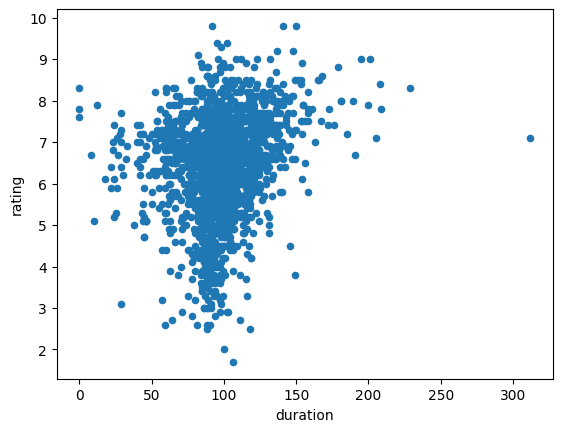

In [22]:
df_cast_count.plot(kind = 'scatter',x = 'duration', y = 'rating')

As is evident from the scatter plot above, the dots are all over the place and we cannot spot any real linear positive or negative correlation between the 2 attributes.

## Genre preference for each actor

In [23]:
%%sql


WITH t1 AS (
SELECT DISTINCT id, trim(person_name) AS person_name, person_id, country_name, genre_name, release_year
FROM master_database
WHERE role_name = 'cast' AND (upper(genre_name) NOT LIKE '%TV%' AND upper(genre_name) NOT LIKE '%INDEPENDENT%' AND 
                             upper(genre_name) NOT LIKE '%SHOWS%' AND 
                             upper(genre_name) NOT LIKE '%INTERNATIONAL%')
    AND genre_name NOT IN ('International Movies','Independent Movies','Docuseries', 'Documentaries'
                                             ,'International TV Shows')
    --AND trim(person_name) = 'Clint Eastwood'
),

--assign ranks to shows for every person-country in the ascending order of their release year
--thus, consecutively released shows will have consecutive ranks
t2 AS (
SELECT *, DENSE_RANK() OVER (PARTITION BY person_id, person_name, country_name ORDER BY release_year, id) as num
FROM t1),

--access the values stored above and below using lag and lead
t3 AS (
SELECT *,
LAG(num) OVER (PARTITION BY person_id, person_name, country_name, genre_name ORDER BY num) AS prev_num,
LEAD(num) OVER (PARTITION BY person_id, person_name, country_name, genre_name ORDER BY num) AS next_num,
COUNT(*) OVER (PARTITION BY person_id, person_name, country_name, genre_name) AS show_count
FROM t2),

--filter only those records with consecutive genre occurences
t4 AS (
SELECT * 
FROM t3
WHERE prev_num = num - 1 AND next_num = num + 1
)


SELECT person_id, person_name, country_name, genre_name, MAX(show_count) as number_of_shows FROM t4 
WHERE person_name != ''
GROUP BY person_id, person_name, country_name, genre_name
ORDER BY person_id




,person_id,person_name,country_name,genre_name,number_of_shows
0,58,Vanessa Hudgens,United States,Children & Family Movies,3
1,63,Ken Jeong,United States,Comedies,5
2,64,Elizabeth Perkins,United States,Comedies,3
3,65,Jane Krakowski,United States,Comedies,7
4,65,Jane Krakowski,United States,Children & Family Movies,4
...,...,...,...,...,...
2443,41110,Joonas Suotamo,United States,Sci-Fi & Fantasy,3
2444,41207,Ricardo Montalban,United States,Comedies,3
2445,41246,Ashley Chin,United Kingdom,Dramas,3
2446,42019,Michael Roof,United States,Action & Adventure,3
